In [70]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.colors
import matplotlib.axes as axes
import matplotlib.ticker as mticker
import itertools
import pandas as pd
import scipy.io
import cartopy

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Loading data

In [2]:
path_models = '/scratch/usr/shkifmmp/reccap/models/' 

In [3]:
mask_SO = xr.open_dataset(path_models + 'reccap_regions_SOsubs.nc').SO_basins_biomes

In [4]:
# mask = scipy.io.loadmat(path_models + 'area_CCSM-WHOI_1_gr_1980-2018_20211125.mat')

In [4]:
mask_SO_r = mask_SO.sel(lon=slice(0,180)) 

mask_SO_aux = mask_SO.sel(lon=slice(-180,0))

mask_SO_aux['lon'] = mask_SO_aux.lon + 360

mask_SO = xr.concat(objs = [mask_SO_r, mask_SO_aux], dim = 'lon')

In [58]:
var = ['talkos', 'mld', 'fice', 'no3os', 'tos', 'sos', 'dissicos', 'po4os']

In [6]:
def process_data(): # create dataset for all the variables including the available models
    files_aux =  glob(path_models + 'mask*') + glob(path_models + 'area*')
    aux_area = xr.Dataset()
    for au in np.arange(0,len(files_aux)):
        if 'mask' in files_aux[au]:
            model_name = files_aux[au].split('sfc_',1)[1].split('_1',1)[0].replace('-','_').replace('.','')
            ma_aux = scipy.io.loadmat(files_aux[au])['mask_sfc_' + model_name]
            aux_area = aux_area.assign({'mask_' + model_name: (('lon','lat'), ma_aux)})
        else:
            model_name = files_aux[au].split('ea_',1)[1].split('_1',1)[0].replace('-','_').replace('.','')
            ma_aux = scipy.io.loadmat(files_aux[au])['area_' + model_name]
            aux_area = aux_area.assign({'area_' + model_name: (('lon','lat'), ma_aux)})
    globals()['area_models'] = aux_area.transpose('lat', 'lon')
    for v in var:
        files = glob(path_models + v + '*')
        aux = xr.Dataset()
        for f in np.arange(0,len(files)):
            model_name = files[f].split('mean_',1)[1].split('_A',1)[0].replace('-','_').replace('.','')
            var_aux = scipy.io.loadmat(files[f])[v + '_mm_mean_' + model_name]
            aux = aux.assign({model_name: (('lon', 'lat', 'time'), var_aux)})
            aux.coords['time'] = np.arange(1,13)
        globals()[v] = aux.transpose('lat','lon', 'time')

In [8]:
np.arange(1,13)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [7]:
process_data()

In [22]:
talkos

<xarray.Dataset>
Dimensions:                  (lon: 360, lat: 180, time: 12)
Coordinates:
  * time                     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lon, lat
Data variables:
    MOM6_Princeton           (lat, lon, time) float64 nan nan ... 2.331 2.337
    FESOM_REcoM_LR           (lat, lon, time) float64 nan nan ... 2.168 2.166
    MRI_ESM2_0               (lat, lon, time) float64 nan nan ... 2.174 2.181
    ORCA1_LIM3_PISCES        (lat, lon, time) float64 nan nan nan ... 2.342 2.36
    ORCA025_GEOMAR           (lat, lon, time) float64 nan nan ... 2.125 2.128
    CCSM_WHOI                (lat, lon, time) float64 nan nan ... 2.027 2.048
    FESOM_REcoM_HR           (lat, lon, time) float64 nan nan ... 2.181 2.181
    NorESM_OC12              (lat, lon, time) float64 nan nan ... 2.186 2.207
    ROMS_SouthernOcean_ETHZ  (lat, lon, time) float64 nan nan nan ... nan nan
    EC_Earth3                (lat, lon, time) float64 nan nan ... 2.254 2.266
    CESM_ETHZ                (lat, lon, time) float32 inf inf inf ... 2.22 2.227
    planktom12               (lat, lon, time) float64 nan nan nan ... 2.093 2.1

In [8]:
def weighted_mean(variable, weight, mask):
    return (variable.where(mask) * weight.where(mask)).sum(('lat','lon')) / weight.sum(('lat', 'lon'))

In [9]:
# weight mean of all models for all variables in the different basins and biomes
suffix = ['_atl_STSS', '_atl_SPSS', '_atl_ICE', '_ind_STSS', '_ind_SPSS', '_ind_ICE', '_pac_STSS', '_pac_SPSS', '_pac_ICE']

for v, i in itertools.product(var, np.arange(0,9)):    #nested loop; globals() get the variables with the specified string_name or create if not existent
    variable = globals()[v]
    aux = xr.Dataset()
    for l in sorted(list(variable.keys())):
        aux_2 = weighted_mean(variable[l].where(mask_SO == i),
                              globals()['area_models']['area_' + l].where(mask_SO == i),
                              globals()['area_models']['mask_' + l].where(mask_SO == i))
        aux = aux.assign({l: (('time'), aux_2.values)})
    aux.coords['time'] = np.arange(1,13)
    globals()[v + suffix[i]] = aux

In [34]:
talkos_atl_SPSS

<xarray.Dataset>
Dimensions:                  (time: 12)
Coordinates:
  * time                     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    CCSM_WHOI                (time) float64 2.186 2.186 2.186 ... 2.188 2.187
    CESM_ETHZ                (time) float64 2.323 2.321 2.319 ... 2.322 2.323
    EC_Earth3                (time) float64 2.311 2.31 2.309 ... 2.313 2.312
    FESOM_REcoM_HR           (time) float64 2.308 2.308 2.307 ... 2.307 2.308
    FESOM_REcoM_LR           (time) float64 2.302 2.301 2.301 ... 2.302 2.302
    MOM6_Princeton           (time) float64 2.33 2.329 2.328 ... 2.331 2.331
    MRI_ESM2_0               (time) float64 2.358 2.357 2.356 ... 2.361 2.359
    NorESM_OC12              (time) float64 2.336 2.335 2.334 ... 2.337 2.337
    ORCA025_GEOMAR           (time) float64 2.37 2.37 2.369 ... 2.371 2.371
    ORCA1_LIM3_PISCES        (time) float64 2.339 2.337 2.337 ... 2.341 2.34
    ROMS_SouthernOcean_ETHZ  (time) float64 2.355 2.355 2.354 ... 2.354 2.355
    planktom12               (time) float64 2.287 2.287 2.287 ... 2.291 2.29

In [38]:
talkos_atl_ICE

<xarray.Dataset>
Dimensions:                  (time: 12)
Coordinates:
  * time                     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/14)
    CCSM_WHOI                (time) float64 2.05 2.057 2.074 ... 2.111 2.076
    CESM_ETHZ                (time) float64 2.244 2.243 2.249 ... 2.277 2.263
    EC_Earth3                (time) float64 2.308 2.323 2.339 ... 2.361 2.321
    FESOM_REcoM_HR           (time) float64 2.332 2.331 2.33 ... 2.327 2.33
    FESOM_REcoM_LR           (time) float64 2.326 2.326 2.325 ... 2.321 2.324
    MOM6_Princeton           (time) float64 2.339 2.337 2.343 ... 2.367 2.356
    ...                       ...
    ORCA025_GEOMAR           (time) float64 2.357 2.359 2.361 ... 2.363 2.358
    ORCA1_LIM3_PISCES        (time) float64 2.323 2.332 2.348 ... 2.378 2.345
    ROMS_SouthernOcean_ETHZ  (time) float64 2.339 2.344 2.345 ... 2.342 2.336
    planktom12               (time) float64 2.334 2.332 2.336 ... 2.363 2.349
    mod_mean                 (time) float64 2.301 2.304 2.31 ... 2.327 2.312
    mod_std                  (time) float64 0.08118 0.08006 ... 0.07084 0.07574

In [37]:
# getting mean and std of variables
for i, j in itertools.product(var, suffix):
    var_aux = globals()[i + j]
    mean_v = var_aux.to_array(dim='new').mean('new') #it creates a relationship between the different variables by new dimension and do the mean in that dim
    std_v = var_aux.to_array(dim='new').std('new') #for standard deviation
#     data_obs = globals()[j + '_ob' + suffix[i]] # getting the observational data
    globals()[i + j] = var_aux.assign(mod_mean = mean_v, mod_std = std_v)#, obs = data_obs) # adding variables to DataSetE.keys()]

## OBSERVATIONAL DATA

In [10]:
path_obs = '/scratch/usr/shkifmmp/reccap/observations/'

In [11]:
# dic
dic_aux = xr.open_mfdataset(glob(path_obs + 'MOB*nc')).DIC.isel(depth=0).squeeze()
dic_aux = dic_aux.reset_coords(['depth'], drop=True)
dic_aux = dic_aux.rename({'month': 'time'})

dic = dic_aux.sel(lon=slice(0,180)) 

dic_aux2 = dic_aux.sel(lon=slice(-180,0))

dic_aux2['lon'] = dic_aux2.lon + 360

dic_ob = xr.concat(objs = [dic, dic_aux2], dim = 'lon')

dic_ob = dic_ob * 1020 * 1e-6 #micromol/kg to mol/m3

dic_ob = dic_ob.where(dic_ob > 0,other=np.nan) #masking land

In [12]:
# MLD

mld_aux = scipy.io.loadmat(glob(path_obs + 'mld*mat')[0])

In [33]:
# mld_aux['mld_int'].shape

In [13]:
mld_2 = xr.Dataset(
    data_vars=dict(
        mld=(['time','lat','lon'], mld_aux['mld_int'])))

mld_ob = mld_2.mld

mld_ob.coords['lat'] = ('lat', mask_SO.coords['lat'].values)
mld_ob.coords['lon'] = ('lon', mask_SO.coords['lon'].values)

mld_ob.coords['time'] = np.arange(1,13)

In [14]:
time = pd.date_range(start='1982-01-16', periods=456, freq='M')

In [15]:
# sos
sos_ob = xr.open_mfdataset(glob(path_obs + 'sss*nc'), decode_times=False).sss

sos_ob = xr.open_mfdataset(glob(path_obs + 'sss*nc'), decode_times=False).sss

sos_ob = sos_ob.transpose()

sos_ob.coords['time'] = time

sos_ob = sos_ob.groupby("time.month").mean().rename({'month': 'time'})

In [16]:
# mask for tos

mask_sss_obs = sos_ob.isel(time=4).squeeze().copy()

mask_sss_obs = mask_sss_obs.where(np.isnan(mask_sss_obs), other=1)

mask_sss_obs = mask_sss_obs.where(mask_sss_obs == 1, other=0)

In [17]:
tos_ob = xr.open_mfdataset(glob(path_obs + 'sst*nc'), decode_times=False).sst.where(mask_sss_obs)

tos_ob = tos_ob.transpose()

tos_ob.coords['time'] = time

tos_ob = tos_ob.groupby("time.month").mean().rename({'month': 'time'})

In [18]:
fice_ob = xr.open_mfdataset(glob(path_obs + 'fice*nc'), decode_times=False).fice

fice_ob = fice_ob.transpose()

fice_ob.coords['time'] = time

fice_ob = fice_ob.groupby("time.month").mean().rename({'month': 'time'})

In [19]:
alk = xr.open_mfdataset(glob(path_obs + 'AT*nc')).AT_NNGv2.isel(depth_level=0)

alk = alk.transpose()
alk = alk.rename({'latitude': 'lat',
                 'longitude': 'lon'})

alk.coords['time'] = np.arange(1,13)

alk = alk * 1020 * 1e-6 #micromol/kg to mol/m3

alk_aux = alk.sel(lon=slice(0,180)) 
alk_aux1 = alk.sel(lon=slice(-180,0))
alk_aux1['lon'] = alk_aux1.lon + 360
talkos_ob = xr.concat(objs = [alk_aux, alk_aux1], dim = 'lon')

In [20]:
po4 = xr.open_mfdataset(glob(path_obs + 'AT*nc')).phosphate.isel(depth_level=0)
po4 = po4.transpose()
po4 = po4.rename({'latitude': 'lat',
                 'longitude': 'lon'})

po4.coords['time'] = np.arange(1,13)

po4 = po4 * 1020 * 1e-6 #micromol/kg to mol/m3

po4_aux = po4.sel(lon=slice(0,180)) 
po4_aux1 = po4.sel(lon=slice(-180,0))
po4_aux1['lon'] = po4_aux1.lon + 360
po4os_ob = xr.concat(objs = [po4_aux, po4_aux1], dim = 'lon')

In [21]:
no3 = xr.open_mfdataset(glob(path_obs + 'AT*nc')).nitrate.isel(depth_level=0)
no3 = no3.transpose()
no3 = no3.rename({'latitude': 'lat',
                 'longitude': 'lon'})

no3.coords['time'] = np.arange(1,13)

no3 = no3 * 1020 * 1e-6 #micromol/kg to mol/m3

no3_aux = no3.sel(lon=slice(0,180)) 
no3_aux1 = no3.sel(lon=slice(-180,0))
no3_aux1['lon'] = no3_aux1.lon + 360
no3os_ob = xr.concat(objs = [no3_aux, no3_aux1], dim = 'lon')

### weightened mean observations

In [131]:
# area
dxdy_aux = scipy.io.loadmat(glob(path_obs + '1x1*.mat')[0])

In [132]:
dxdy = xr.Dataset(
    data_vars=dict(
        dx=(['lat','lon'], dxdy_aux['dx']),
        dy=(['lat','lon'], dxdy_aux['dy'])))

In [133]:
area_1x1 = dxdy.dx * dxdy.dy

area_1x1.coords['lat'] = ('lat', mask_SO.coords['lat'].values)
area_1x1.coords['lon'] = ('lon', mask_SO.coords['lon'].values)

In [134]:
var

['talkos', 'mld', 'fice', 'no3os', 'tos', 'sos', 'dissicos', 'po4os']

In [153]:
obs = {'talkos_ob': talkos_ob, 'mld_ob': mld_ob, 'fice_ob': fice_ob, 'no3os_ob': no3os_ob, 'tos_ob': tos_ob, 'sos_ob': sos_ob,
       'dissicos_ob': dic_ob, 'po4os_ob': po4os_ob}

In [136]:
# also using for the obs
def weighted_mean_obs(variable, weight):
    return (variable * weight).sum(('lat','lon')) / weight.sum(('lat', 'lon'))

In [137]:
for d, i in itertools.product(obs, np.arange(0,9)):        #nested loop; globals() get the variables with the specified string_name or create if not existent
    data = obs[d]
    
    if (d == 'po4os_ob') or (d == 'no3os_ob') or (d == 'talkos_ob'):
        area_wm = area_1x1.where((area_1x1.lat <= po4os_ob.lat.max().values) & (area_1x1.lat >= po4os_ob.lat.min().values),drop=True)
        mask_wm = mask_SO.where((mask_SO.lat <= po4os_ob.lat.max().values) & (mask_SO.lat >= po4os_ob.lat.min().values), drop=True)
        
    elif d == 'dic_ob':
        area_wm = area_1x1.where((area_1x1.lat <= dic_ob.lat.max().values) & (area_1x1.lat >= dic_ob.lat.min().values),drop=True)
        mask_wm = mask_SO.where((mask_SO.lat <= dic_ob.lat.max().values) & (mask_SO.lat >= dic_ob.lat.min().values), drop=True)
        
    else:
        area_wm = area_1x1
        mask_wm = mask_SO
        
    globals()[d + suffix[i]] = weighted_mean_obs(data.where(mask_wm == i), 
                                                 area_wm.where(mask_wm == i))

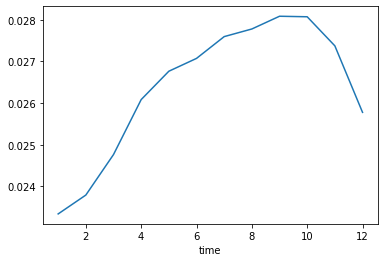

In [142]:
no3os_ob_atl_ICE.plot()

In [52]:
# po4os_ob_atl_ICE.plot()
# po4os_atl_ICE.CCSM_WHOI.plot()

## PLOTS

In [ ]:
# 9 plots (1 for each region); 8 subplots (each variable); 9 plots for models only, 9 plots models+obs

In [51]:
mod_color = {'CCSM_WHOI': 'blue', 'CESM_ETHZ': 'red', 'CNRM_ESM2_1': 'orange',
            'EC_Earth3': 'gray', 'FESOM_REcoM_HR': 'green', 'FESOM_REcoM_LR': 'magenta',
            'MOM6_Princeton': 'cyan', 'MRI_ESM2_0': 'darkviolet', 'NorESM_OC12': 'lime',
            'ORCA025_GEOMAR': 'gold', 'ORCA1_LIM3_PISCES': 'chocolate', 'ROMS_SouthernOcean_ETHZ': 'dodgerblue',
            'planktom12': 'deeppink', 'mean': 'black'}

In [118]:
suffix

['_atl_STSS',
 '_atl_SPSS',
 '_atl_ICE',
 '_ind_STSS',
 '_ind_SPSS',
 '_ind_ICE',
 '_pac_STSS',
 '_pac_SPSS',
 '_pac_ICE']

In [189]:
def plot_timeseries(suffix):
    "Function for plotting        "
    "suffix = region to br plotted"
    suf = suffix
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(23, 16))
    xticks= ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    
    for j in np.arange(0, len(var)):
        variable = globals()[var[j] + suffix]
        keys = [*variable.keys()][None:-2]
        for i in np.arange(0,len(keys)):
            variable[keys[i]].plot(ax=axs.flatten()[j], label=keys[i], color= mod_color[keys[i]]) # plot for each variable
        variable['mod_mean'].plot(ax=axs.flatten()[j], label='Mean', color= 'k', linewidth=3.5)

        if var[j] == 'tos':
            axs.flatten()[j].set_ylabel(var[j] + ' ($^{\circ}$C)', fontsize=16)
        elif var[j] == 'mld':
            axs.flatten()[j].set_ylabel(var[j] + ' (m)', fontsize=16)
            axs.flatten()[j].set_title(suffix[1:None], fontsize=20, y=1.05)
        else:
            axs.flatten()[j].set_ylabel(var[j], fontsize=16)
            
        if (var[j] == 'talkos') or (var[j] == 'no3os') or (var[j] == 'po4os') or (var[j] == 'dissicos'):
            axs.flatten()[j].set_ylabel(var[j] + ' (mol m$^{-3}$)', fontsize=16)
            
        axs.flatten()[j].set_xticks(np.arange(1,13))
        axs.flatten()[j].set_xticklabels(xticks)


    fig.delaxes(axs.flatten()[8]) #remove the last axs
    
    leg = axs[1,0].legend(bbox_to_anchor=(2.5, -0.2), loc='upper left', borderaxespad=0., fontsize=15)
    for line in leg.get_lines():
        line.set_linewidth(2.7)
    for ax in axs.flat:
        ax.yaxis.set_tick_params(labelsize = 15)
        ax.xaxis.set_tick_params(labelsize = 15)
        ax.grid()
        ax.set_xlabel(None)
        ax.set_xlim(1,12)
      
    savepath='/scratch/usr/shkifmmp/notebooks/shared-notebooks/figures/'
    plt.savefig(savepath + 'reccap_2022_models' + suffix +'.png', format='png', facecolor="w", bbox_inches='tight')
#     plt.tight_layout()
#         ax.xaxis.set_tick_params(rotation=0, labelsize = 15)
#         ax.set_xticks(ticks)
#         ax.xaxis.set_major_formatter(mticker.FuncFormatter(m_fmt))

In [187]:
def plot_timeseries_obs(suffix):
    "Function for plotting        "
    "suffix = region to br plotted"
    suf = suffix
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(36, 12))
    xticks= ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    
    for j in np.arange(0, len(var)):
        variable = globals()[var[j] + suffix]
        if var[j] == 'dissicos':
            obs_plot = globals()['dic_ob' + suffix]
        else:
            obs_plot = globals()[var[j] + '_ob' + suffix]

        keys = [*variable.keys()][None:-2]
        
        for i in np.arange(0,len(keys)):
            variable[keys[i]].plot(ax=axs.flatten()[j], color= 'tab:green', linewidth=1, alpha = 0.7, label = '_') # plot for each variable        
        variable['mod_mean'].plot(ax=axs.flatten()[j], label='Models', color= 'tab:green', linewidth=3.5)
        obs_plot.plot(ax=axs.flatten()[j], label='Data products', color= 'tab:blue', linewidth=3.5)
        axs.flatten()[j].fill_between(variable.time.values, variable.mod_mean - variable.mod_std, 
                         variable.mod_mean + variable.mod_std, alpha = 0.1, color ='tab:green')
    
        if var[j] == 'tos':
            axs.flatten()[j].set_ylabel(var[j] + ' ($^{\circ}$C)', fontsize=16)
        elif var[j] == 'mld':
            axs.flatten()[j].set_ylabel(var[j] + ' (m)', fontsize=16)
#             axs.flatten()[j].set_title(suffix[1:None], fontsize=20, y=1.05)
        else:
            axs.flatten()[j].set_ylabel(var[j], fontsize=16)
            
        if (var[j] == 'talkos') or (var[j] == 'no3os') or (var[j] == 'po4os') or (var[j] == 'dissicos'):
            axs.flatten()[j].set_ylabel(var[j] + ' (mol m$^{-3}$)', fontsize=16)
            
        axs.flatten()[j].set_xticks(np.arange(1,13))
        axs.flatten()[j].set_xticklabels(xticks)

    plt.suptitle(suffix[1:None], fontsize=20, y=0.94)
#     fig.delaxes(axs.flatten()[8]) #remove the last axs
    
#     leg = axs[1,0].legend(bbox_to_anchor=(2.5, -0.2), loc='upper left', borderaxespad=0., fontsize=15)
    leg = axs[0,3].legend(loc='lower right', fontsize=14)

    for line in leg.get_lines():
        line.set_linewidth(2.7)
    for ax in axs.flat:
        ax.yaxis.set_tick_params(labelsize = 15)
        ax.xaxis.set_tick_params(labelsize = 15)
        ax.grid()
        ax.set_xlabel(None)
        ax.set_xlim(1,12)

    leg = axs[0,3].legend(loc='lower right', fontsize=14)

    savepath='/scratch/usr/shkifmmp/notebooks/shared-notebooks/figures/'
    plt.savefig(savepath + 'reccap_2022_models_obs' + suffix +'.png', format='png', facecolor="w", bbox_inches='tight')
#     plt.tight_layout()

/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


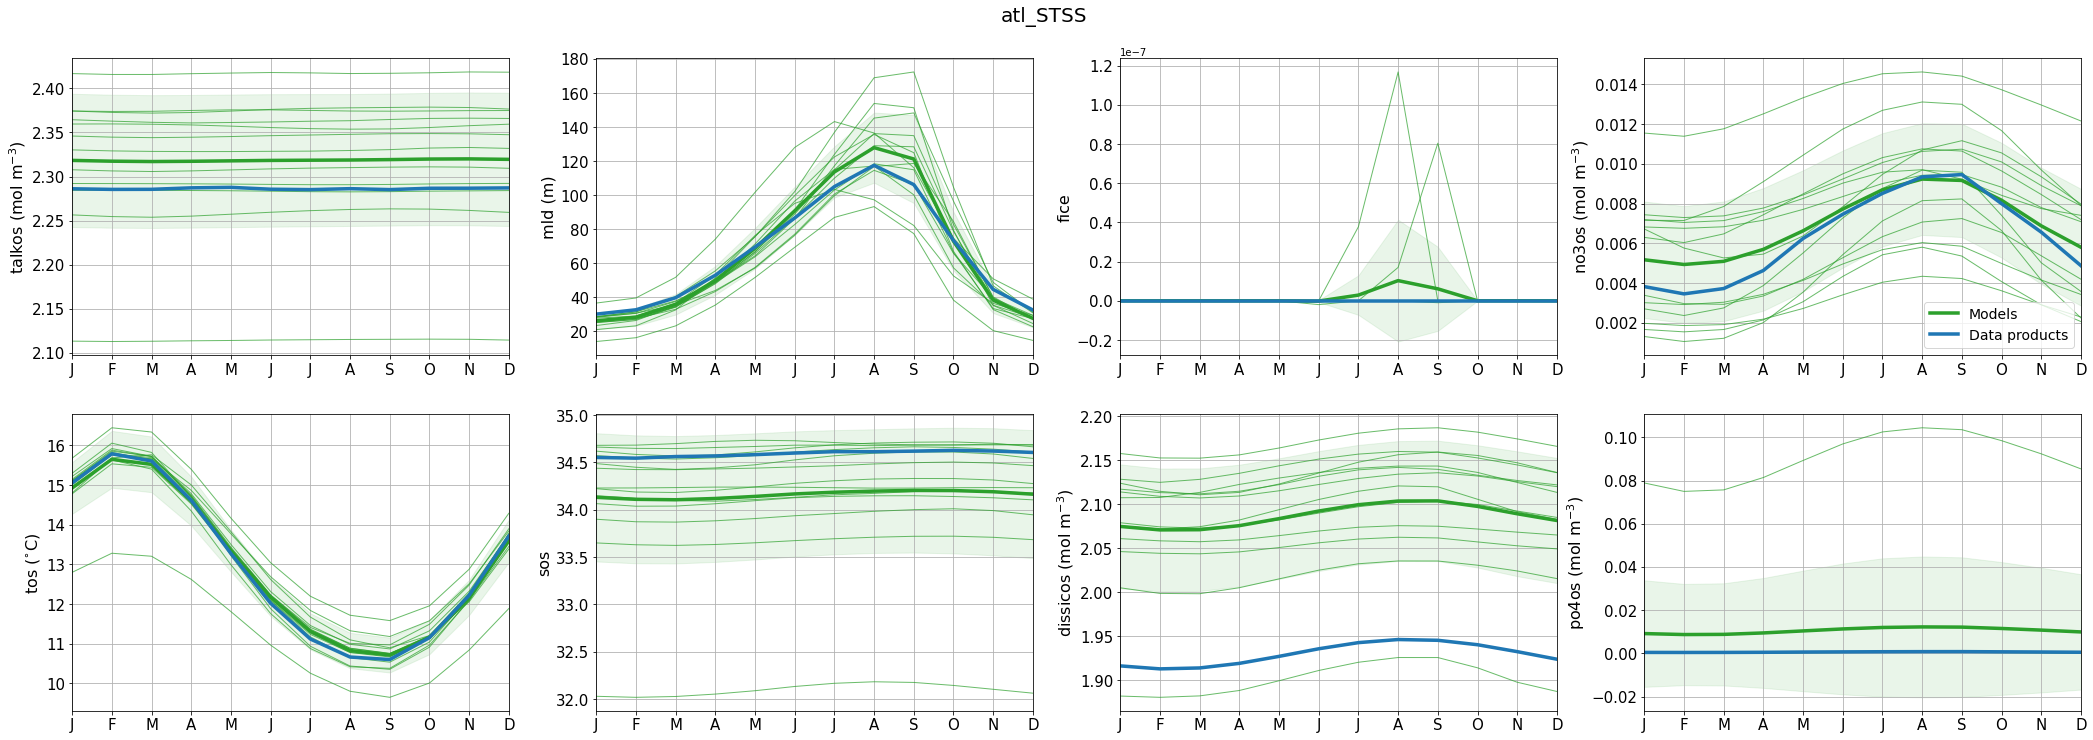

In [186]:
plot_timeseries_obs(suffix[0])

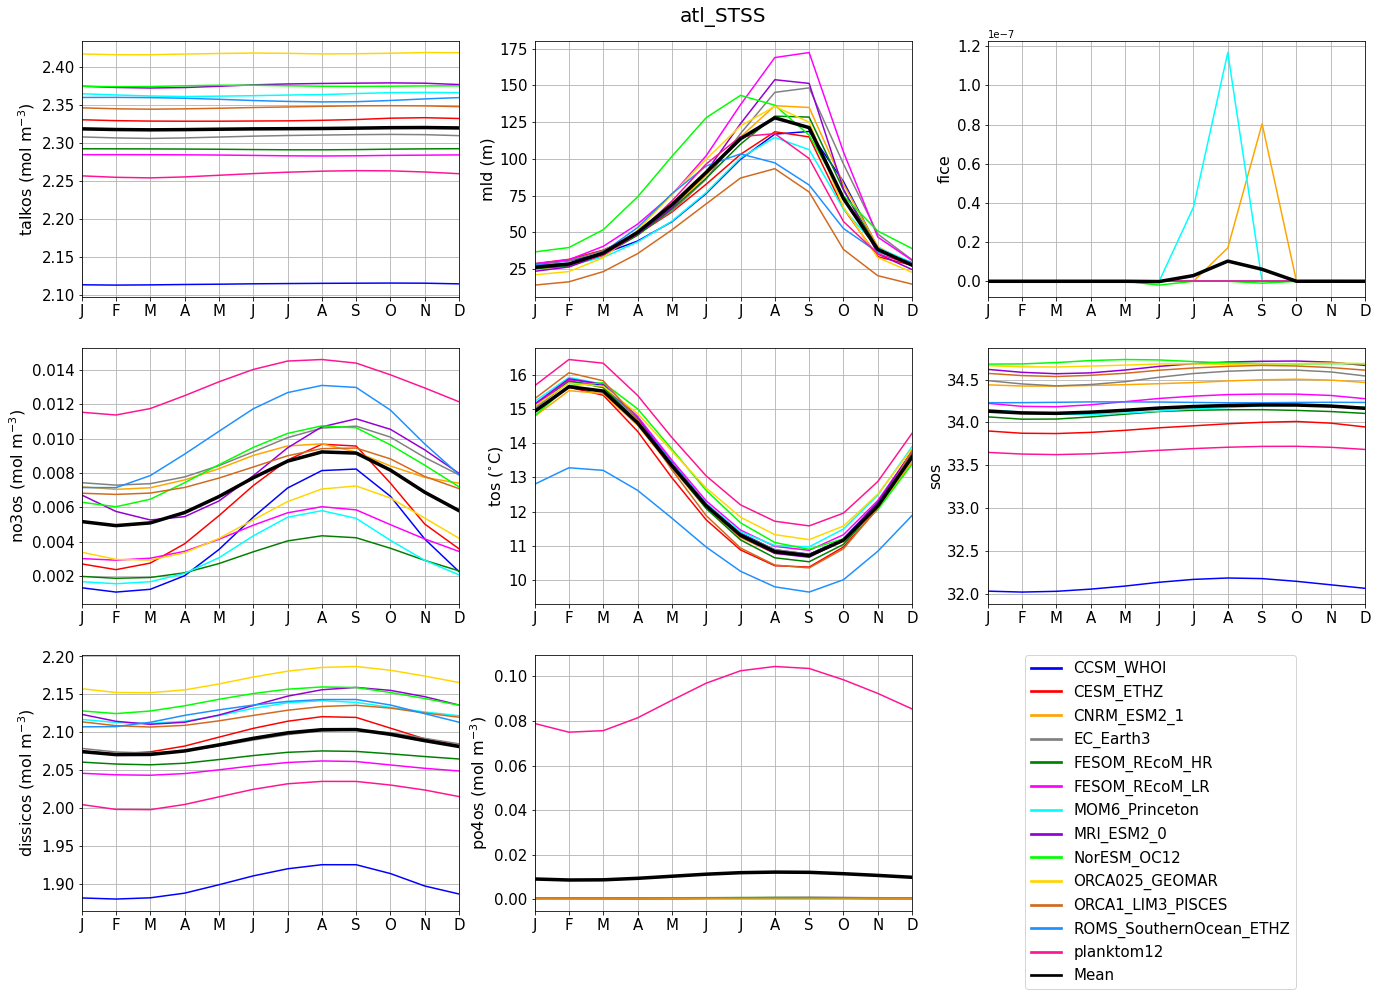

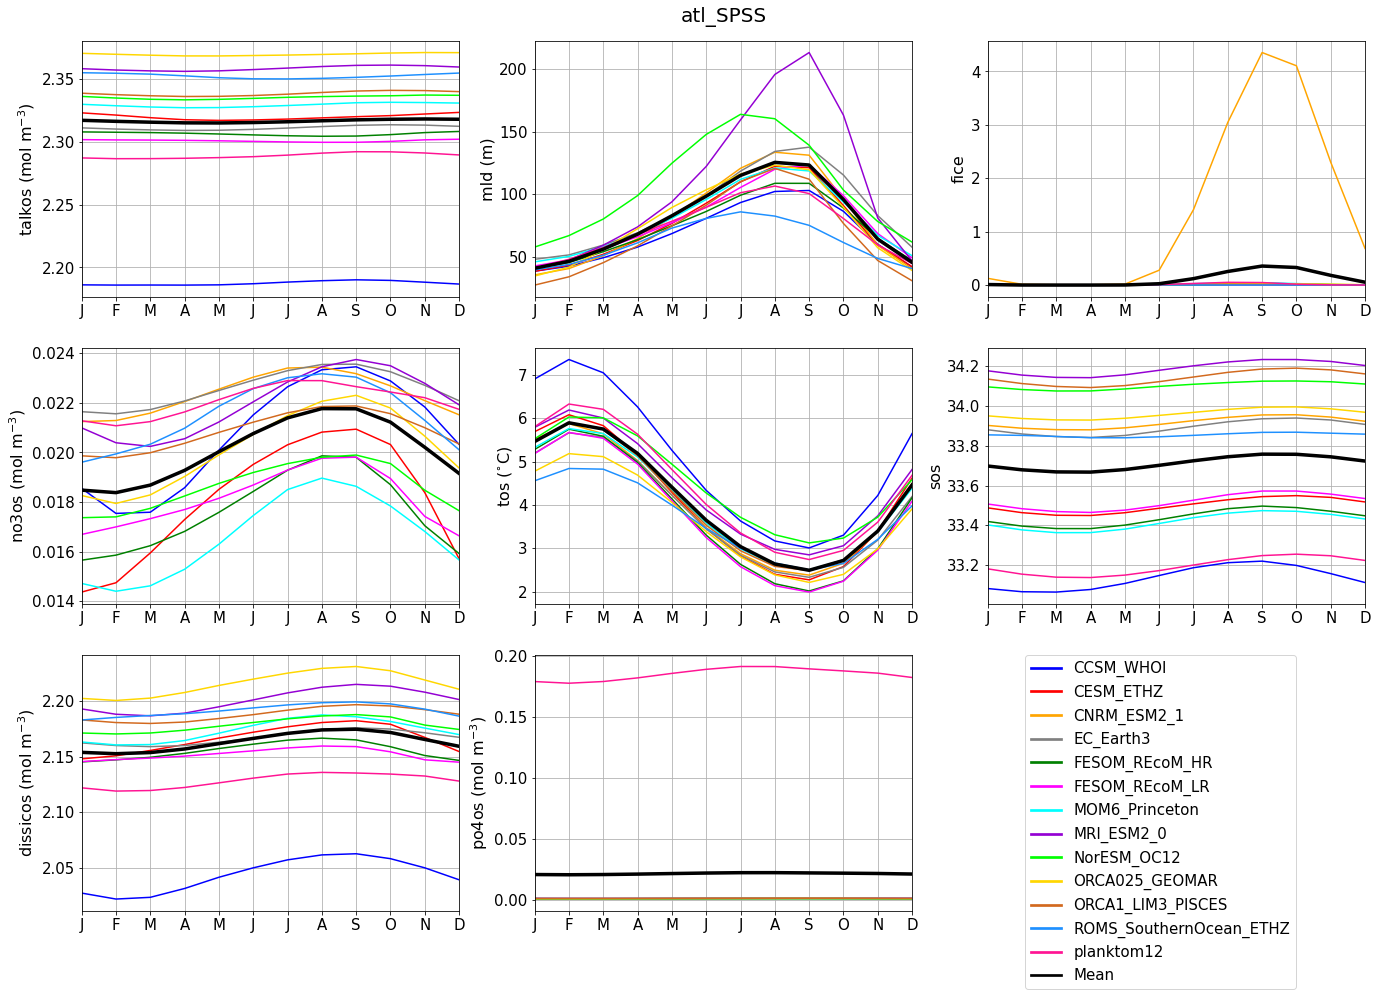

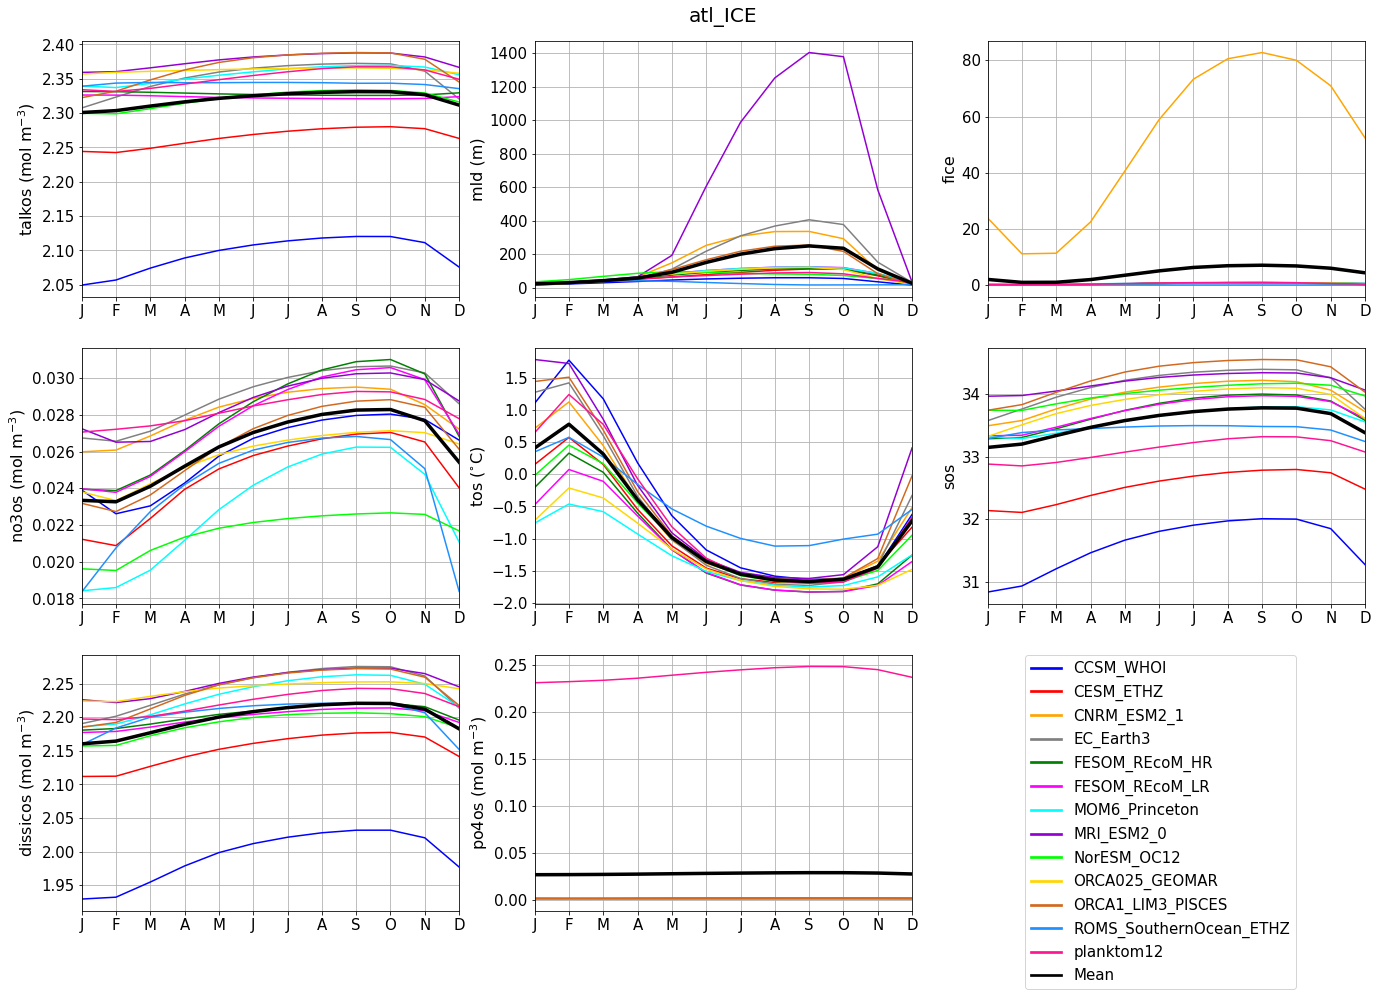

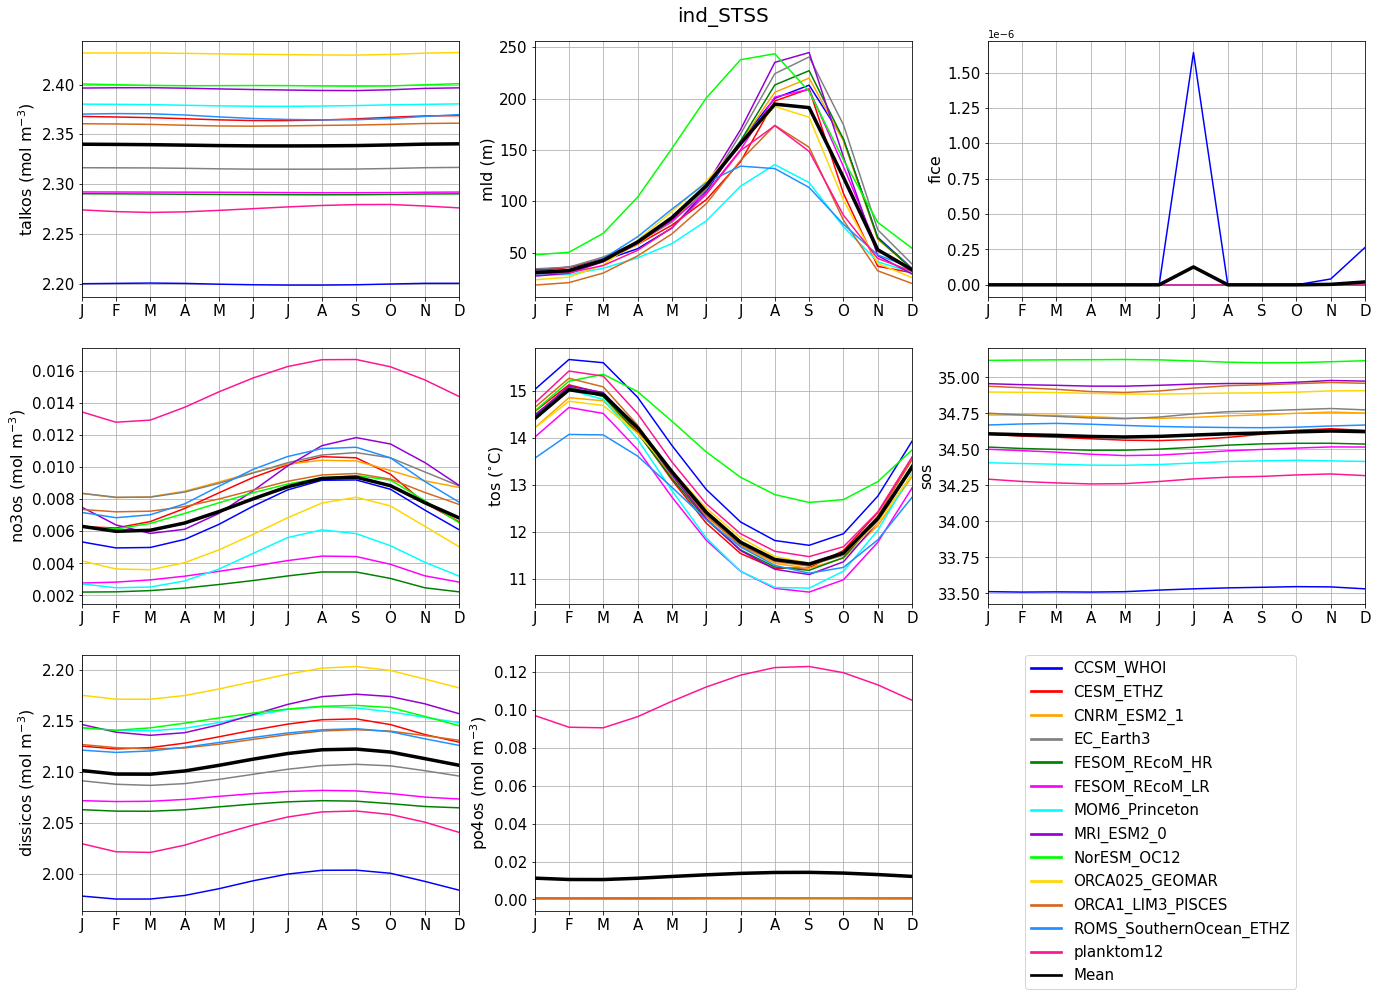

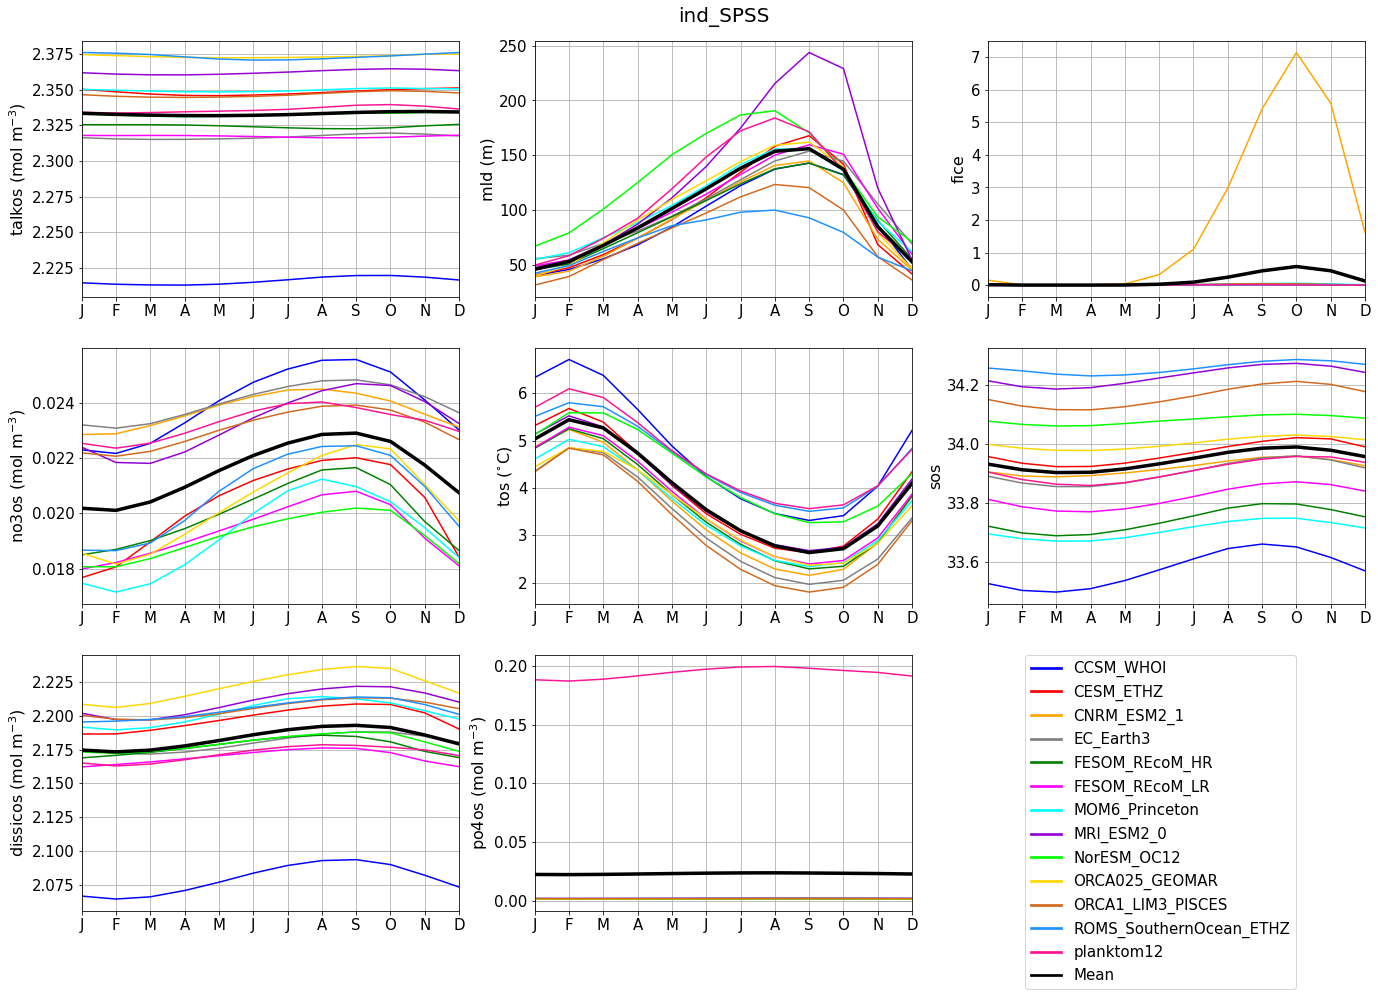

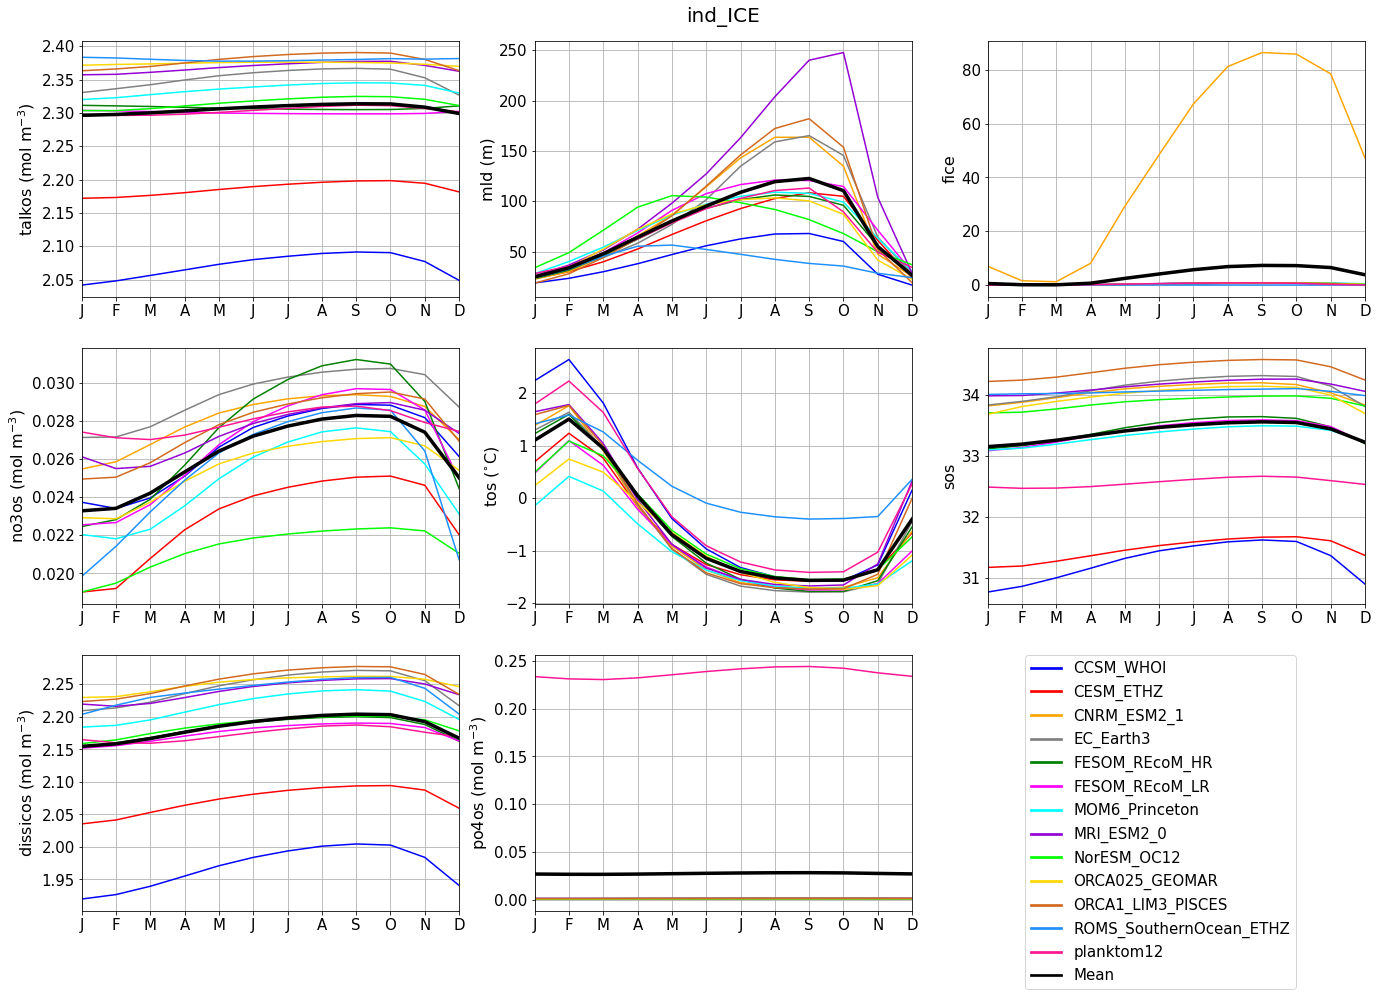

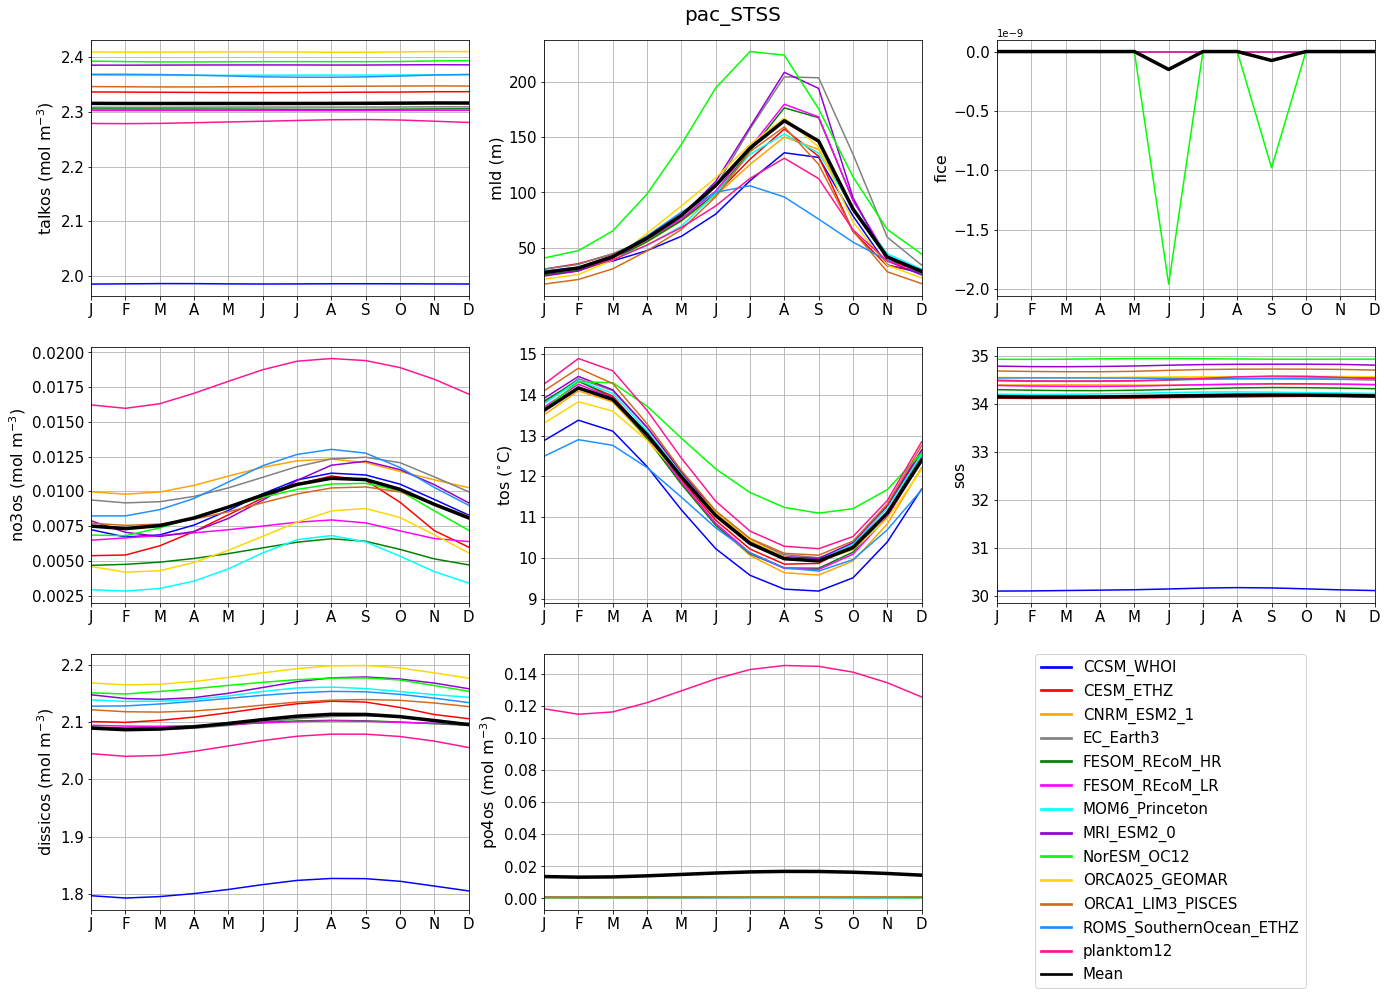

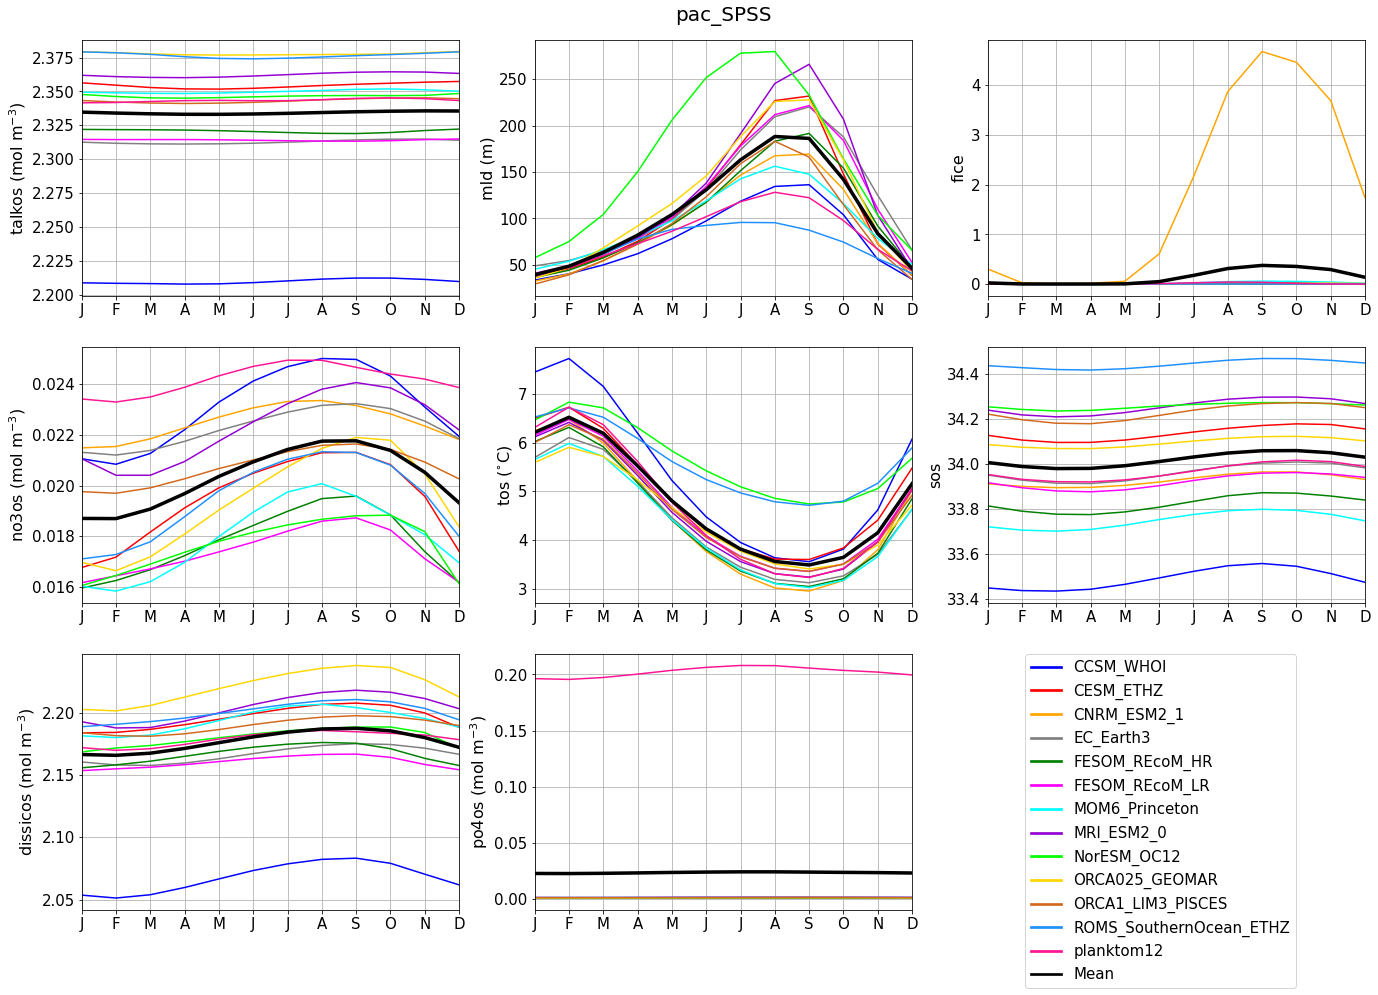

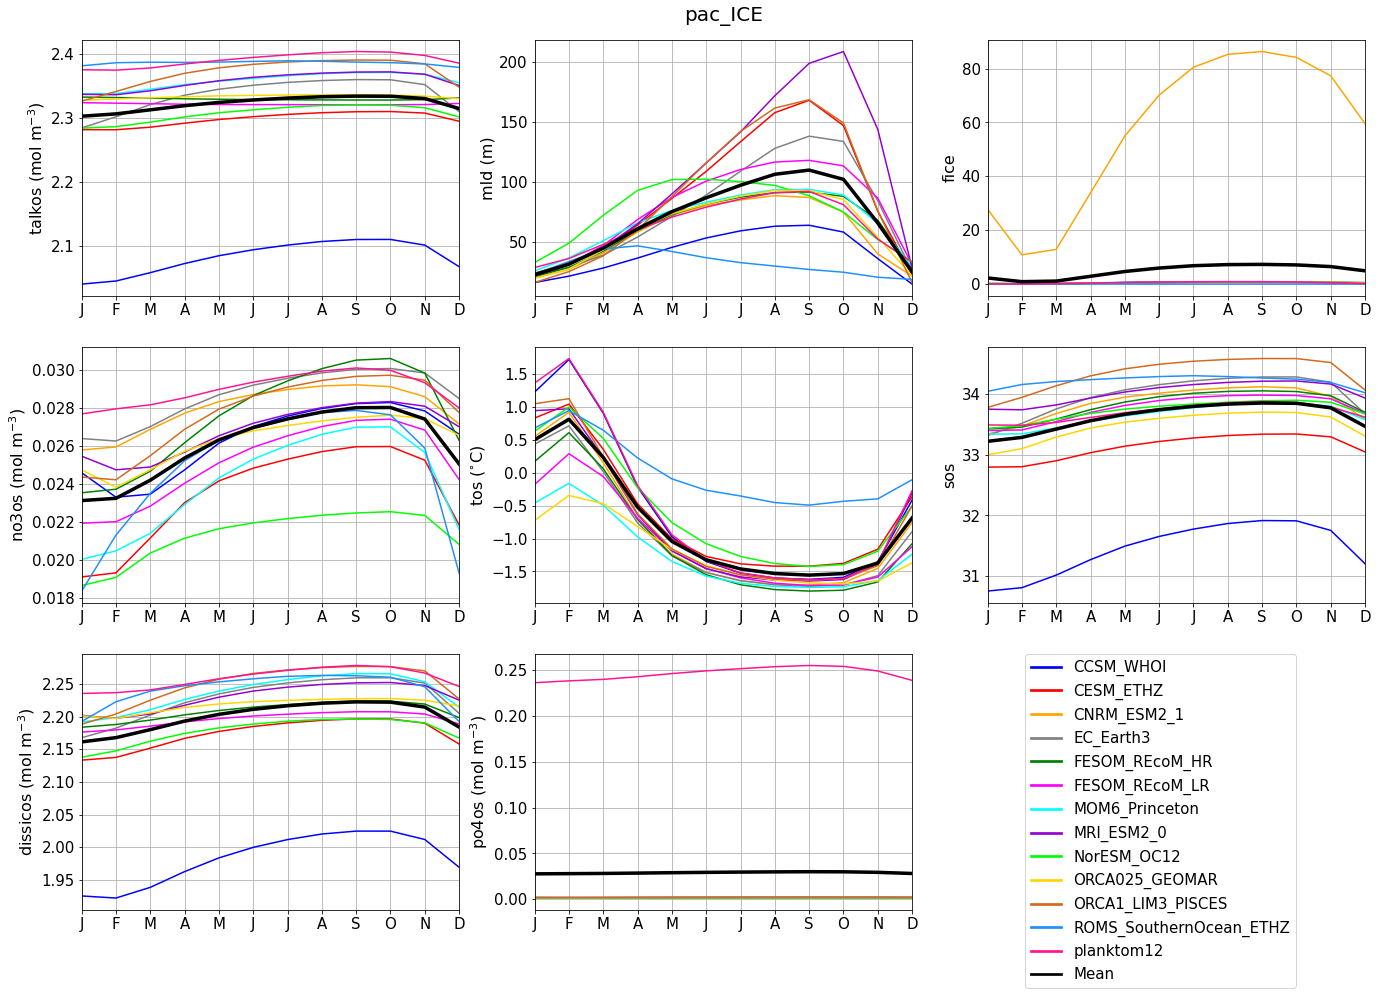

In [190]:
for i in suffix:
    plot_timeseries(i)

['_ind_SPSS']

In [ ]:
talko

In [69]:
ax.yaxis.set_tick_params?

Object `ax.yaxis.set_tick_params` not found.


In [ ]:
ticks = [np.datetime64('1980-%02d-15'%month) for month in range(1, 13)] # for plotting all the months (ticks)
month_fmt = mdates.DateFormatter('%b')
def m_fmt(x, pos=None): #getting only first letter of Month
    return month_fmt(x)[0]

def plot_timeseries(prefix):
    "Function for plotting          "
    "prefix = variable to be plotted"
    pref = prefix
    models_plot = models.copy()
    axis_lim = np.zeros((3,3))
    axis_lim_min = np.zeros((3,3))
    #to remove from models list if the models does not have the specific variable
    if pref == 'po4os':
        rem_list = ['FESOM_REcoM_LR', 'FESOM_REcoM_HR']
        [models_plot.pop(key, None) for key in rem_list]
    if pref == 'fice':
        models_plot.pop('EC_Earth3', None)
        
    fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (24,15))    
    
    for j in np.arange(0,3):
        dic_atl = globals()[pref + suffix[j]]
        dic_ind = globals()[pref + suffix[j+3]]
        dic_pac = globals()[pref + suffix[j+6]]

    # Atl
    
        for m in models_plot:
            dic_atl[m].plot(ax=axs[j,0], linewidth = 1.5)
        dic_atl.mod_mean.plot(ax=axs[j,0], color = 'k', linewidth = 3.5)
#         axs[j,0].fill_between(dic_atl.time.values, dic_atl.mod_mean - dic_atl.mod_std, 
#                          dic_atl.mod_mean + dic_atl.mod_std, alpha = 0.1, color ='tab:gray')
        axs[j,0].set_xlabel(None)
        axs[j,0].margins(x=0)
        axis_lim_min[j,0] = axs[j,0].get_ylim()[0]
        axis_lim[j,0] = axs[j,0].get_ylim()[1]
        
        
        # y_labels
        if prefix == 'dissicos':
            axs[j,0].set_ylabel('DISSICOS (mol m$^{-3}$)', fontsize = 15)
        if prefix == 'fice':
            axs[j,0].set_ylabel('FICE', fontsize = 15)
        if prefix == 'spco2':
            axs[j,0].set_ylabel('SPCO2 ($\mu$atm)', fontsize = 15)
        if prefix == 'tos':
            axs[j,0].set_ylabel('TOS ($^{\circ}$C)', fontsize = 15)
        if prefix == 'sos':
            axs[j,0].set_ylabel('SOS', fontsize = 15)
        if prefix == 'no3os':
            axs[j,0].set_ylabel('NO3OS (mol m$^{-3}$)', fontsize = 15)
        if prefix == 'po4os':
            axs[j,0].set_ylabel('PO4OS (mol m$^{-3}$)', fontsize = 15)
        if prefix == 'mld':
            axs[j,0].set_ylabel('MLD (m)', fontsize = 15)
        if prefix == 'talkos':
            axs[j,0].set_ylabel('TALKOS (mol m$^{-3}$)', fontsize = 15)

    # Ind
        for m in models_plot:
            dic_ind[m].plot(ax=axs[j,1], linewidth = 1.5)
        dic_ind.mod_mean.plot(ax=axs[j,1], color = 'k', linewidth = 3.5)
#         axs[j,1].fill_between(dic_ind.time.values, dic_ind.mod_mean - dic_ind.mod_std, 
#                          dic_ind.mod_mean + dic_ind.mod_std, alpha = 0.1, color ='tab:gray')
        axs[j,1].set_ylabel(None)
        axs[j,1].set_xlabel(None)
        axs[j,1].margins(x=0)
        axis_lim_min[j,1] = axs[j,1].get_ylim()[0]
        axis_lim[j,1] = axs[j,1].get_ylim()[1]

    # Pac
        for m in models_plot:
            dic_pac[m].plot(ax=axs[j,2], linewidth = 1.5, label = m)
        dic_pac.mod_mean.plot(ax=axs[j,2], color = 'k', linewidth = 3.5, label = 'Mean')
#         axs[j,2].fill_between(dic_pac.time.values, dic_pac.mod_mean - dic_pac.mod_std, 
#                          dic_pac.mod_mean + dic_pac.mod_std, alpha = 0.1, color ='tab:gray')
        axs[j,2].set_ylabel(None)
        axs[j,2].set_xlabel(None)
        axs[j,2].margins(x=0)
        axis_lim_min[j,2] = axs[j,2].get_ylim()[0]
        axis_lim[j,2] = axs[j,2].get_ylim()[1]

        
    # adding text to the plot
    axs[0,0].text(0.01, 0.03,'STSS-Atl', color='k', transform=axs[0,0].transAxes, fontsize = 16)
    axs[1,0].text(0.01, 0.03,'SPSS-Atl', color='k', transform=axs[1,0].transAxes, fontsize = 16)
    axs[2,0].text(0.01, 0.03,'ICE-Atl', color='k', transform=axs[2,0].transAxes, fontsize = 16)
    
    axs[0,1].text(0.01, 0.03,'STSS-Ind', color='k', transform=axs[0,1].transAxes, fontsize = 16)
    axs[1,1].text(0.01, 0.03,'SPSS-Ind', color='k', transform=axs[1,1].transAxes, fontsize = 16)
    axs[2,1].text(0.01, 0.03,'ICE-Ind', color='k', transform=axs[2,1].transAxes, fontsize = 16)
        
    axs[0,2].text(0.01, 0.03,'STSS-Pac', color='k', transform=axs[0,2].transAxes, fontsize = 16)
    axs[1,2].text(0.01, 0.03,'SPSS-Pac', color='k', transform=axs[1,2].transAxes, fontsize = 16)
    axs[2,2].text(0.01, 0.03,'ICE-Pac', color='k', transform=axs[2,2].transAxes, fontsize = 16)  
    
    #ticks parameters
    for i in np.arange(0,3):
        axs[0,i].set_ylim(bottom = axis_lim_min[0,:].min(), top = axis_lim[0,:].max())
        axs[1,i].set_ylim(bottom = axis_lim_min[1,:].min(), top = axis_lim[1,:].max())
        
        if pref == 'mld':
            axs[2,i].set_ylim(bottom = axis_lim_min[2,:].min(), top = 800)
        else:
            axs[2,i].set_ylim(bottom = axis_lim_min[2,:].min(), top = axis_lim[2,:].max())
#         axs[0,i].set_xticks(ticks)
#         axs[0,i].xaxis.set_ticklabels([])
#         axs[1,i].set_xticks(ticks)
#         axs[1,i].xaxis.set_ticklabels([])
#         axs[2,i].xaxis.set_tick_params(rotation=0, labelsize = 15)
#         axs[2,i].set_xticks(ticks)
#         axs[2,i].xaxis.set_major_locator(mdates.DayLocator(bymonthday = [16,15]))
#         axs[2,i].xaxis.set_major_formatter(mticker.FuncFormatter(m_fmt))
    
    
    for ax in axs.flat:
        ax.yaxis.set_tick_params(labelsize = 13)
        ax.grid()
        ax.xaxis.set_tick_params(rotation=0, labelsize = 15)
        ax.set_xticks(ticks)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(m_fmt))
    
    #adding legend next to the plot
    leg = axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=15)
    
    for line in leg.get_lines():
        line.set_linewidth(2.7)
    
    savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/figures/'
    plt.savefig(savepath + 'reccap2_' + pref + '_timeseries.png', format='png', facecolor="w",  bbox_inches='tight')